Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-11-02 по 2022-11-08 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

### Ваша задача — проанализировать данные АB-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).

Сравните данные этими тестами. Почему тесты сработали так как сработали? 

Опишите потенциальную ситуацию, когда такое изменение могло произойти. 

Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.


In [68]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
import numpy as np

sns.set(font_scale=1.5)

In [1]:
connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'simulator_20221120',
              'user':'student', 
              'password':'dpo_python_2020'
              }

In [58]:
query = """
SELECT 
  user_id,
  exp_group,
  CTR,
  global_ctr,
  likes,
  views,
  (likes + 5 * global_ctr) / (views + 5) as smoothed_ctr
FROM (
      SELECT 
        l.user_id as user_id,
        l.exp_group as exp_group,
        l.CTR as CTR,
        r.global_ctr as global_ctr,
        l.likes as likes,
        l.views as views
      FROM (
            SELECT 
              user_id,
              exp_group,
              sum(action = 'like') / sum(action = 'view') as CTR,
              sum(action = 'like') as likes,
              sum(action = 'view') as views
            FROM simulator_20221120.feed_actions 
            WHERE toDate(time) >= '2022-11-02' and toDate(time) <= '2022-11-08' and exp_group in [1, 2]
            GROUP BY user_id, exp_group
            ) as l
      JOIN (
            SELECT 
              exp_group,
              sum(action = 'like') / sum(action = 'view') as global_ctr
            FROM simulator_20221120.feed_actions 
            WHERE toDate(time) >= '2022-11-02' and toDate(time) <= '2022-11-08' and exp_group in [1, 2]
            GROUP BY exp_group
            ) as r 
      ON l.exp_group = r.exp_group
      )
"""

In [59]:
df = ph.read_clickhouse(query, connection=connection)

In [60]:
df.head()

,user_id,exp_group,CTR,global_ctr,likes,views,smoothed_ctr
0,109963,1,0.200000,0.208027,3,15,0.202007
1,26117,1,0.226950,0.208027,32,141,0.226302
2,138232,1,0.246575,0.208027,18,73,0.244104
3,26295,1,0.270492,0.208027,33,122,0.268033
4,18392,1,0.218750,0.208027,7,32,0.217301


### Первый взгляд на данные, визуализация

Перед проведением статистических тестов посмотрим на получившиеся данные. Это поможет сделать предварительные выводы и выбрать стат.тест. 

<AxesSubplot:xlabel='CTR', ylabel='Count'>

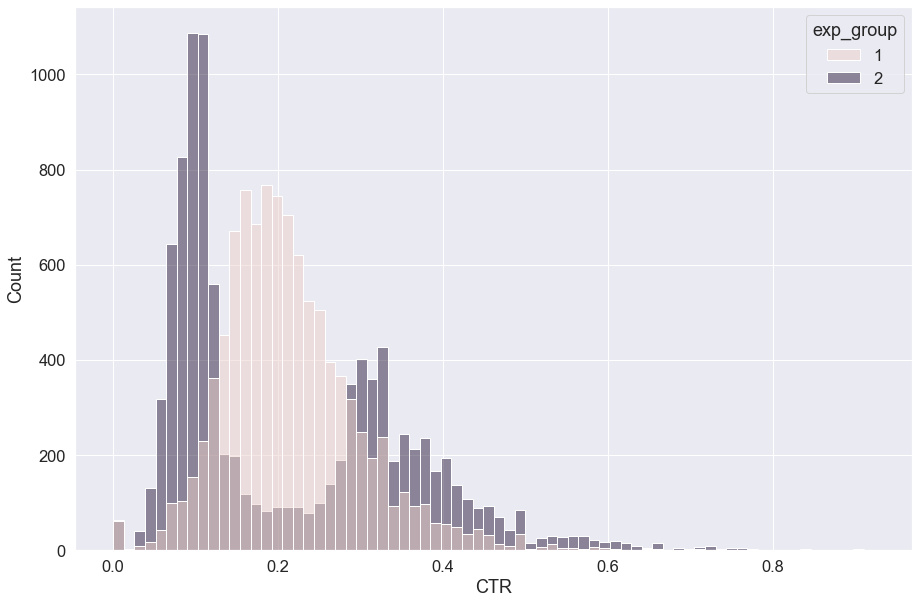

In [61]:
plt.figure(figsize=(15,10))
sns.histplot(data=df, x='CTR', hue='exp_group')

<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

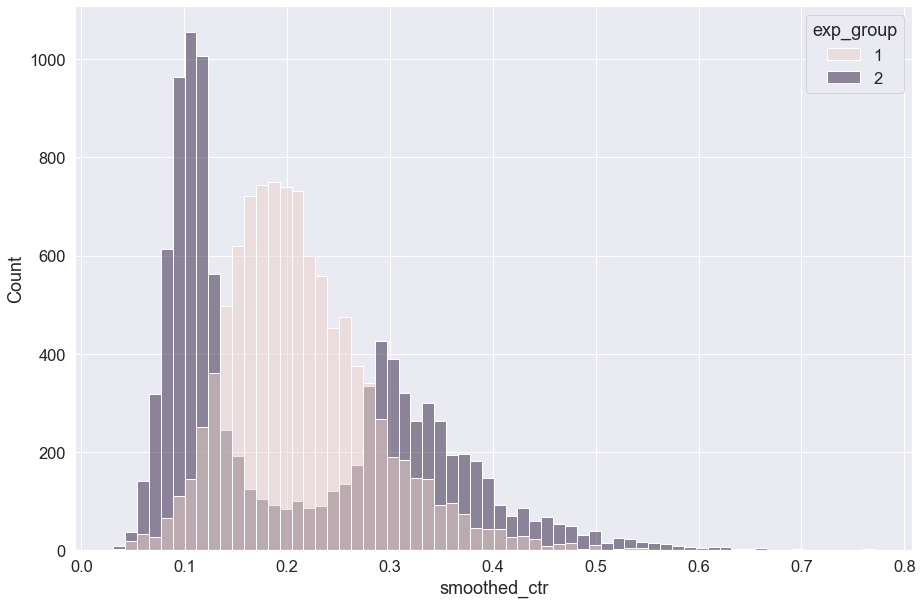

In [62]:
plt.figure(figsize=(15,10))
sns.histplot(data=df, x='smoothed_ctr', hue='exp_group')

####  Предварительные выводы:

1) Введение новой рекомендательный системы точно значимо повлияло на CTR

2) Форма распределения тестовой группы говорит о том, что стоит крепко задуматься над примененнием стат.тестов

3) Формы распределений сглаженного и обычного CTR, на первый взгляд, значимо не различаются, поэтому применть для анализа сглаженный CTR нецелесообразно из-за его непрогнозируемых особенностей

4) Бимодальность распределения подталкивает к дополнительному анализу "холмов", возможно это две отдельные группы пользователей, имеющие сходства, и на эти группы по разному повлияли нововведения 

## Посмотрим на описательные характеристики распределенеий 

In [112]:
df \
    .groupby('exp_group', as_index=False) \
    .agg({'global_ctr':'mean','CTR':'mean'}) \
    .rename(columns={'CTR':'mean_ctr_by_user'})

,exp_group,global_ctr,mean_ctr_by_user
0,1,0.208027,0.215605
1,2,0.198060,0.214419


Видно, что CTR уменьшился, что в сумме с визуальной картинкой и характером распределений уже достаточно, чтобы отвергнуть нововведения

## Посмотрим как отработают статистические тесты 

### T-test

In [47]:
st.ttest_ind(df[df.exp_group==1].CTR, df[df.exp_group==2].CTR, equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Тест показал равенство средних. Кажется, что, это не является достоверным результатом, тк высок риск неправильного срабатывания теста при таких исходных распределениях. На мой взгляд, применять его для исследования в данном случае не стоит.

### Манна-Уитни

In [48]:
st.mannwhitneyu(df[df.exp_group==1].CTR, df[df.exp_group==2].CTR)

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест показывает разницу в поюзерном CTR, при этом сложно по другому интерпретировать результаты. Учитывая, что нас больше интересует глобальный CTR по группам, следует поискать альтернативу.

### Пуассоновский бутсрэп

В данном случае очевидны преимущества перед предыдущими методами: неприхотливость к распределениям, возможность подсчета любой метрики и простая интерпретируемость результатов. Будем считать, что главное условие по репрезентативности выборок выполняется. 

In [78]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):

    poisson_bootstraps1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [79]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [80]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

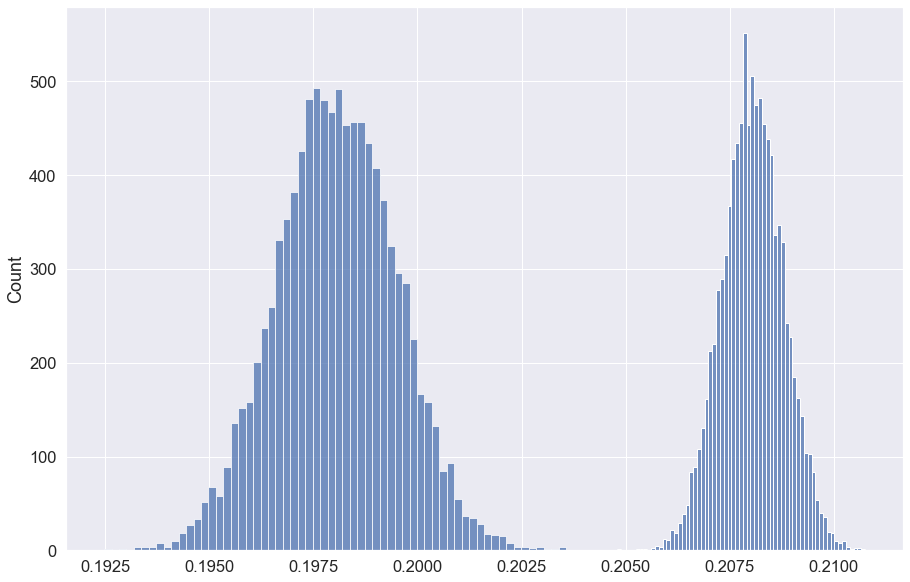

In [83]:
plt.figure(figsize=(15,10))
sns.histplot(ctr1)
sns.histplot(ctr2)

Text(0.5, 1.0, 'CTR1-CTR2')

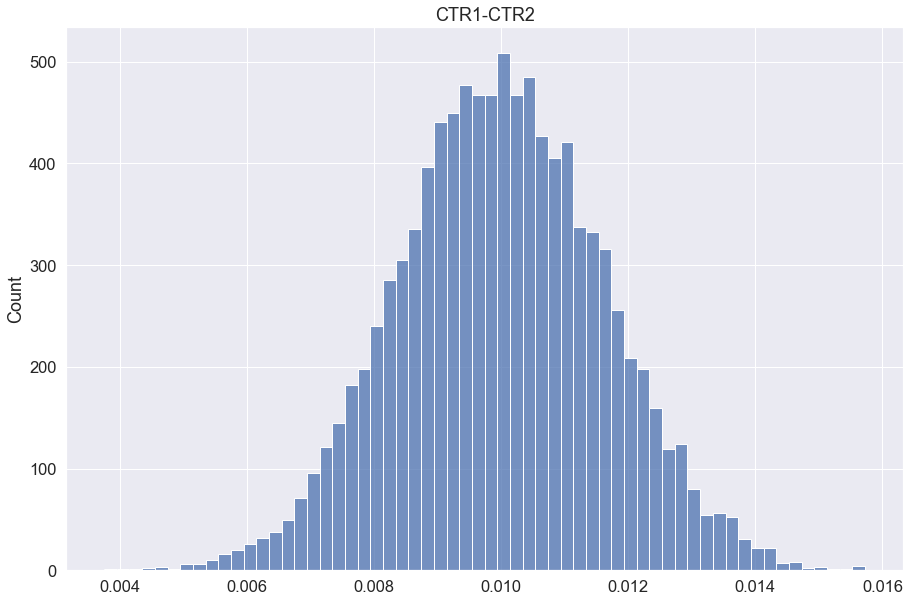

In [85]:
plt.figure(figsize=(15,10))
sns.histplot(ctr2-ctr1)
plt.title('CTR1-CTR2')

Видим, что глобальный CTR по группам значимо различается, разница не "цепляет" 0. Новая рекомендательная система привела к падению глобального CTR.

#### В качестве метода для исследования, в данном случае, пуассоновский бутстрэп показал себя более надежным

## Бакетное преобразование

In [94]:
q = """
SELECT 
    exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (
    SELECT 
        exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2022-11-02' and '2022-11-08' and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id
    )
GROUP BY exp_group, bucket
"""

In [95]:
df_2 = ph.read_clickhouse(q, connection=connection)

In [98]:
df_2.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271


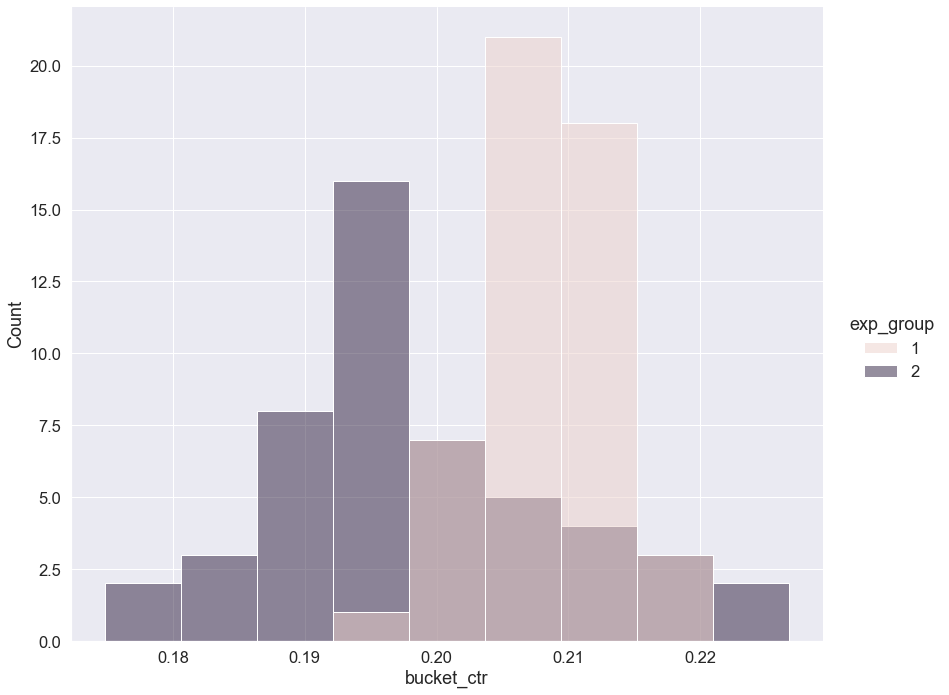

In [104]:
sns.displot(data=df_2, x='bucket_ctr', hue='exp_group', aspect=1.2, height=10)

Бакетное преобразование позволяет "нормализовать" данные и сделать их более пригодными к анализу

Распределения бакетного CTR хотя бы являются унимодальными, возможно, t-тест сможет хорошо отработать.  

In [105]:
st.ttest_ind(df_2[df_2.exp_group==1].bucket_ctr, df_2[df_2.exp_group==2].bucket_ctr, equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [107]:
st.mannwhitneyu(df_2[df_2.exp_group==1].bucket_ctr, df_2[df_2.exp_group==2].bucket_ctr, alternative='two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Оба теста уловили значимые различия с p_value одного порядка. 

#### Все отработало корректно

## Вывод

Перед проведением статистических тестов всегда важно посмотреть на полученные данные. Это поможет 1) выбрать статистический тест; 2) сделать предварительные выводы;

В нашем случае предварительный анализ графиков показал, что различия между группами существенные, а также какие именно это различия. В тестовой группе пользователи разделились на две части - часть из них (большая) стала лайкать меньше, оставшаяся часть - больше. Такое поведение не является желаемым в контексте нашей задачи, что уже говорит о негативном влиянии новой фичи. Если в дополнениии к этому просто посмотреть на глобальный CTR, на то, как изменился глобальный CTR по группам (а он уменьшился), то по уже имеющимся данным можно отвергнуть новую рекомендательную систему на выводах только визуализации.

При необходимости более точного исследования статистический тест нужно выбирать осторожно, исходя из форм распредлений, количества данных и особенностей задачи. В нашем случае применение t-теста напрямую могло привести к ошибочным результатам, оптимальным является применение бакетного преобразования либо пуассоновского бутспрэпа (при таком количестве данных он не занимает много времени).

Ну, а новую рекомендательную систему выпускать в продакшн точно не стоит. 